# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

Mounted at /content/drive


Load Data

In [2]:
try:
  X_train = np.load('/content/drive/MyDrive/Final_Project_ML_OL/data/X_train_processed.npy')
  X_val = np.load('/content/drive/MyDrive/Final_Project_ML_OL/data/X_val_processed.npy')
  X_test = np.load('/content/drive/MyDrive/Final_Project_ML_OL/data/X_test_processed.npy')
  y_train = pd.read_csv('/content/drive/MyDrive/Final_Project_ML_OL/data/y_train.csv').values.ravel()
  y_val = pd.read_csv('/content/drive/MyDrive/Final_Project_ML_OL/data/y_val.csv').values.ravel()
  print('Loaded preprocessed arrays.')
except Exception as e:
  print('Preprocessed arrays not found; falling back to raw files. Error:', e)
  preprocessor = joblib.load('/content/drive/MyDrive/Final_Project_ML_OL/data/preprocessor.joblib')
  df = train_raw.copy()
  y = df['Transported']
  X = df.drop(columns=['Transported','PassengerId'])
  X_processed = preprocessor.transform(X)


Loaded preprocessed arrays.


Combine train and validation and retrain model

In [3]:
try:
  X_full_train = np.vstack([X_train, X_val])
  y_full_train = np.concatenate([y_train, y_val])
  print('Combined X_train and X_val into X_full_train')
except:
  X = train_raw.drop(columns=['Transported','PassengerId'])
  y_full_train = train_raw['Transported'].values
  preprocessor = joblib.load('/content/drive/MyDrive/Final_Project_ML_OL/data/preprocessor.joblib')
  X_full_train = preprocessor.transform(X)

final_model = RandomForestClassifier(
  n_estimators=200,
  min_samples_split=5,
  min_samples_leaf=4,
  random_state=42,
  n_jobs=-1
)

final_model.fit(X_full_train, y_full_train)
print('Final model trained on full train+val set.')

joblib.dump(final_model, '/content/drive/MyDrive/Final_Project_ML_OL/data/final_model.joblib')
print('Saved final model to Drive.')


Combined X_train and X_val into X_full_train
Final model trained on full train+val set.
Saved final model to Drive.


Cross-validation

In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = ['accuracy','precision','recall','f1']
cv_results = cross_validate(final_model, X_full_train, y_full_train, cv=cv, scoring=scoring, n_jobs=-1)

cv_summary = {metric: (cv_results[f'test_{metric}'].mean(), cv_results[f'test_{metric}'].std()) for metric in scoring}
print('CV summary:')
print(cv_summary)

pd.DataFrame({k: [v[0]] for k,v in cv_summary.items()}).to_csv('/content/drive/MyDrive/Final_Project_ML_OL/data/final_cv_summary.csv', index=False)

CV summary:
{'accuracy': (np.float64(0.7989219761102336), np.float64(0.018584679803808502)), 'precision': (np.float64(0.8035073943430311), np.float64(0.02549693840039023)), 'recall': (np.float64(0.7964848010437051), np.float64(0.019138036185362958)), 'f1': (np.float64(0.7996863964320776), np.float64(0.016764104044472605))}


Evaluation

In [5]:
try:
  y_val_pred = final_model.predict(X_val)
  metrics = {
    'accuracy': accuracy_score(y_val, y_val_pred),
    'precision': precision_score(y_val, y_val_pred),
    'recall': recall_score(y_val, y_val_pred),
    'f1': f1_score(y_val, y_val_pred)
  }
  print('Validation metrics after retraining on full set:')
  print(metrics)
  pd.DataFrame([metrics]).to_csv('/content/drive/MyDrive/Final_Project_ML_OL/data/final_validation_metrics.csv', index=False)
except Exception as e:
  print('No separate validation available to evaluate. Error:', e)


Validation metrics after retraining on full set:
{'accuracy': 0.8849913743530765, 'precision': 0.8806306306306306, 'recall': 0.8926940639269406, 'f1': 0.8866213151927438}


Visualizations

Could not create feature importance plot: [Errno 2] No such file or directory: '/content/drive/MyDrive/Final_Project_ML_OL/data/feature_names.joblib'


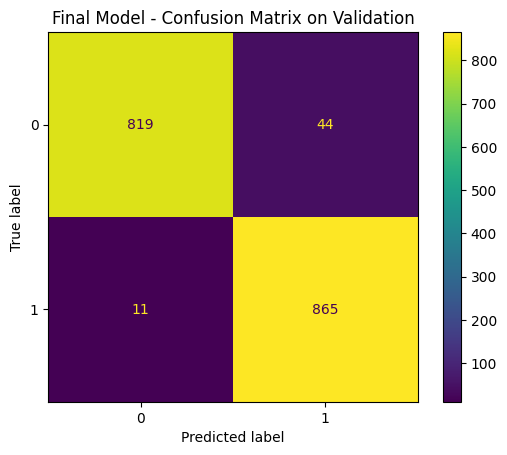

In [ ]:
try:
  importances = final_model.feature_importances_
  feature_names = joblib.load('/content/drive/MyDrive/Final_Project_ML_OL/data/feature_names.joblib')
  fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
  plt.figure(figsize=(10,6))
  fi.plot.bar()
  plt.title('Top Feature Importances')
  plt.tight_layout()
  plt.savefig('/content/drive/MyDrive/Final_Project_ML_OL/report_images/final_feature_importances.png')
  plt.show()
except Exception as e:
  print('Could not create feature importance plot:', e)

try:
  cm = confusion_matrix(y_val, y_val_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Final Model - Confusion Matrix on Validation')
  plt.savefig('/content/drive/MyDrive/Final_Project_ML_OL/report_images/final_confusion_matrix.png')
  plt.show()
except Exception as e:
  print('Confusion matrix not created:', e)
